In [6]:
isinstance({'a': 'b'}, dict)

True

In [1]:
from rechunker import api

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:61128 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [7]:
import zarr
import dask
import dask.array as dsa
import numpy as np
from matplotlib import pyplot as plt

In [9]:
zarr.create?

Signature:
zarr.create(
    shape,
    chunks=True,
    dtype=None,
    compressor='default',
    fill_value=0,
    order='C',
    store=None,
    synchronizer=None,
    overwrite=False,
    path=None,
    chunk_store=None,
    filters=None,
    cache_metadata=True,
    cache_attrs=True,
    read_only=False,
    object_codec=None,
    **kwargs,
)
Docstring:
Create an array.

Parameters
----------
shape : int or tuple of ints
    Array shape.
chunks : int or tuple of ints, optional
    Chunk shape. If True, will be guessed from `shape` and `dtype`. If
    False, will be set to `shape`, i.e., single chunk for the whole array.
    If an int, the chunk size in each dimension will be given by the value
    of `chunks`. Default is True.
dtype : string or dtype, optional
    NumPy dtype.
compressor : Codec, optional
    Primary compressor.
fill_value : object
    Default value to use for uninitialized portions of the array.
order : {'C', 'F'}, optional
    Memory layout to be used within each

In [5]:
!rm -rf /Users/rpa/Code/zarr_rechunker/test_data
base_dir = "/Users/rpa/Code/zarr_rechunker/test_data"

store_source = f'{base_dir}/source.zarr'
shape = (8000, 8000)
source_chunks = (200, 8000)
dtype = 'f4'

a_source = zarr.ones(shape, chunks=source_chunks,
                     dtype=dtype, store=store_source)

target_store = f'{base_dir}/target.zarr'
temp_store = f'{base_dir}/temp.zarr'
max_mem = 25600000
target_chunks = (8000, 200)
int_del, target_del = api.rechunk_zarr2zarr_w_dask(a_source, target_chunks, max_mem,
                                 target_store, temp_store=temp_store)

Two step rechunking


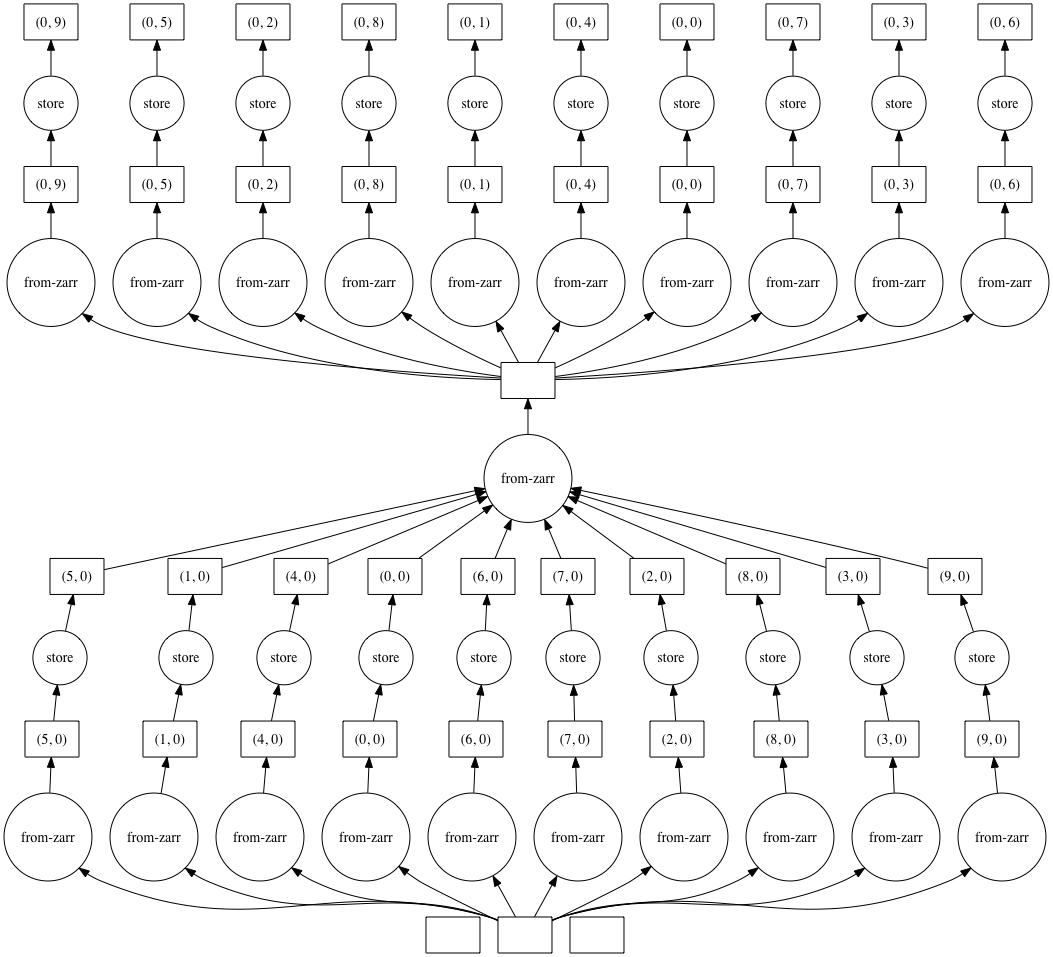

In [6]:
# get the two graphs as dicts
int_dsk = dask.utils.ensure_dict(int_del.dask)
target_dsk = dask.utils.ensure_dict(target_del.dask)

# find the root store key representing the read
root_keys = []
for key in target_dsk:
    if isinstance(key, str):
        if key.startswith('from-zarr'):
            root_keys.append(key)
assert len(root_keys) == 1
root_key = root_keys[0]


# now rewrite the graph
target_dsk[root_key] = (lambda a, *b: a, target_dsk[root_key], *int_dsk[int_del.key])
target_dsk.update(int_dsk)

dask.visualize(target_dsk)

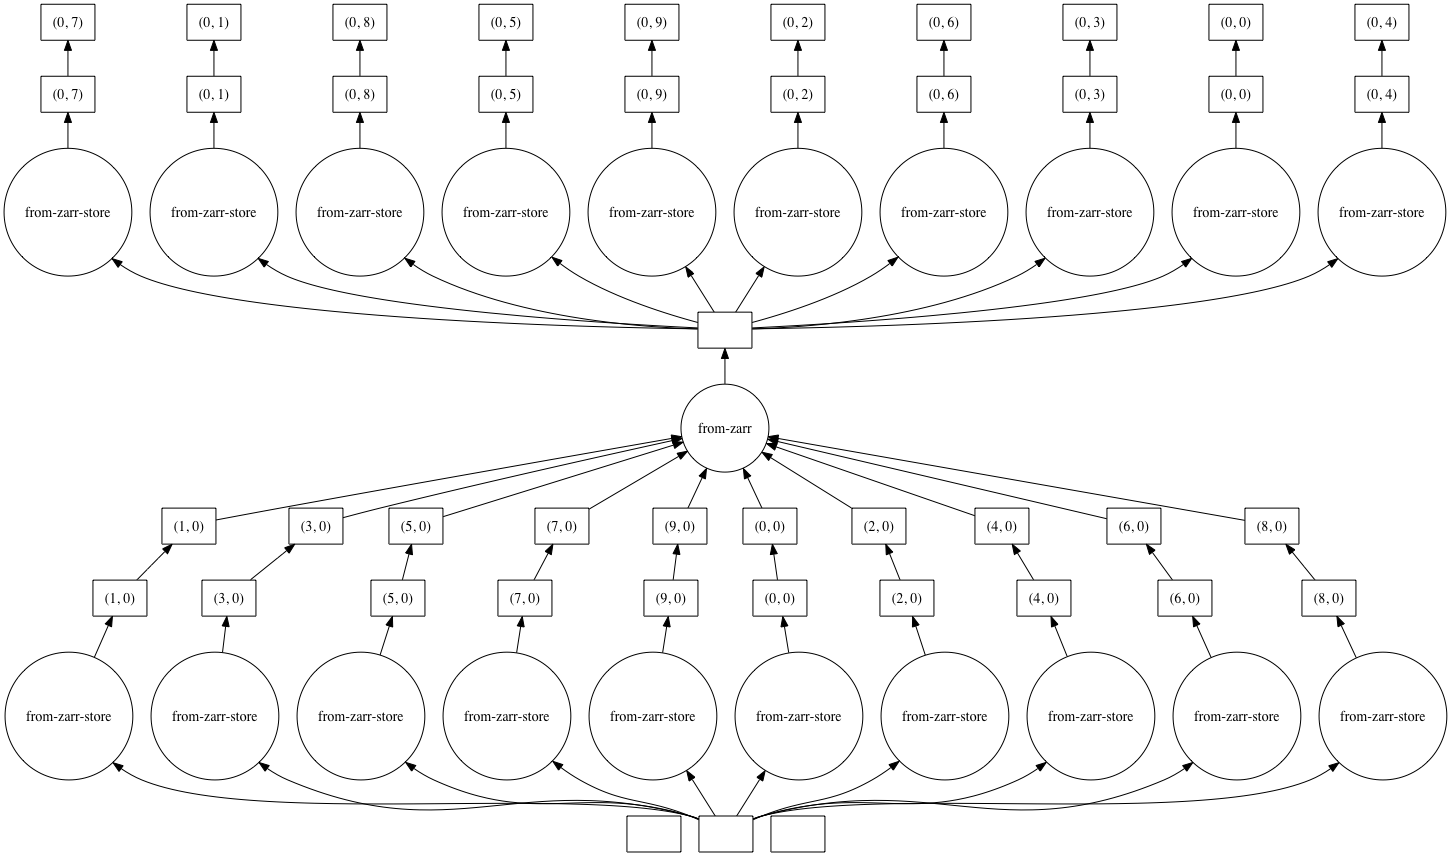

In [7]:
from dask.optimization import fuse
from dask.delayed import Delayed
dsk_fused, deps = fuse(target_dsk)
# try skipping fusion -- it causes problems
#dsk_fused = target_dsk

delayed_fused = Delayed(target_del.key, dsk_fused)
delayed_fused.visualize()

In [8]:
delayed_fused.compute();

In [9]:
a_src = dsa.from_zarr(store_source)
a_int = dsa.from_zarr(temp_store)
a_tar = dsa.from_zarr(target_store)
display(a_src)
display(a_int)
display(a_tar)

dask.array<from-zarr, shape=(8000, 8000), dtype=float32, chunksize=(200, 8000), chunktype=numpy.ndarray>

dask.array<from-zarr, shape=(8000, 8000), dtype=float32, chunksize=(800, 200), chunktype=numpy.ndarray>

dask.array<from-zarr, shape=(8000, 8000), dtype=float32, chunksize=(8000, 200), chunktype=numpy.ndarray>

In [16]:
assert dsa.equal(a_tar, 1).all().compute()

In [ ]:
np.testing.assert_equal(a_target[:], np.ones(a_target.shape, a_target.dtype))

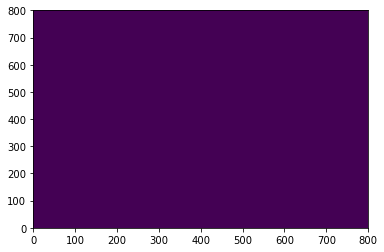

In [45]:
plt.pcolormesh(dsa.coarsen(np.mean, d_int, {0: 10, 1: 10}))

In [29]:
assert dsa.equal(, np.ones(a_target.shape, a_target.dtype))

In [15]:
a_tar.mean().compute()

1.0